# Depixelizing Pixel Art using Deep Neural Networks
---
- Author: Diego Inácio
- GitHub: [github.com/diegoinacio](https://github.com/diegoinacio)
- Notebook: [pixel-art-depixelization-deepNN.ipynb](https://github.com/diegoinacio/creative-coding-notebooks/blob/master/ML-and-AI/pixel-art-depixelization-deepNN.ipynb)
---
A pretty naive approach that *upscales* and *depixelizes* a very low-res pixel art using deep *Neural Network*.

The main idea is given the 2D coordinate inputs, get the relative pixel color as the output. To avoid the color interpolation and *blurry* results, store the original color pallete and transpose it using the concept of *one-hot* encodation.

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

import tensorflow as tf

In [2]:
plt.rcParams['figure.figsize'] = (20, 10)

## Data exploration
---
Read a very low-res pixel art image (preferably 8bits to avoid a very large color pallete).

In [3]:
### Read input image ###
img_in = Image.open('../_data/pixel-art-mario.png')
img_in = np.asarray(img_in)/255
n1, n2, c = img_in.shape

### Split channels ###
R, G, B = img_in[:,:,0], img_in[:,:,1], img_in[:,:,2]

### Get color pallete ###
color_pallete = np.unique(
    np.array([R.ravel(), G.ravel(), B.ravel()]).T,
    axis=0
)
color_pallete = color_pallete[color_pallete.sum(axis=1).argsort()]

### Coordiantes ###
T, S = np.mgrid[0:n1, 0:n2]
# Standardize coordinates
S = (S - S.mean())/S.std()
T = (T - T.mean())/T.std()

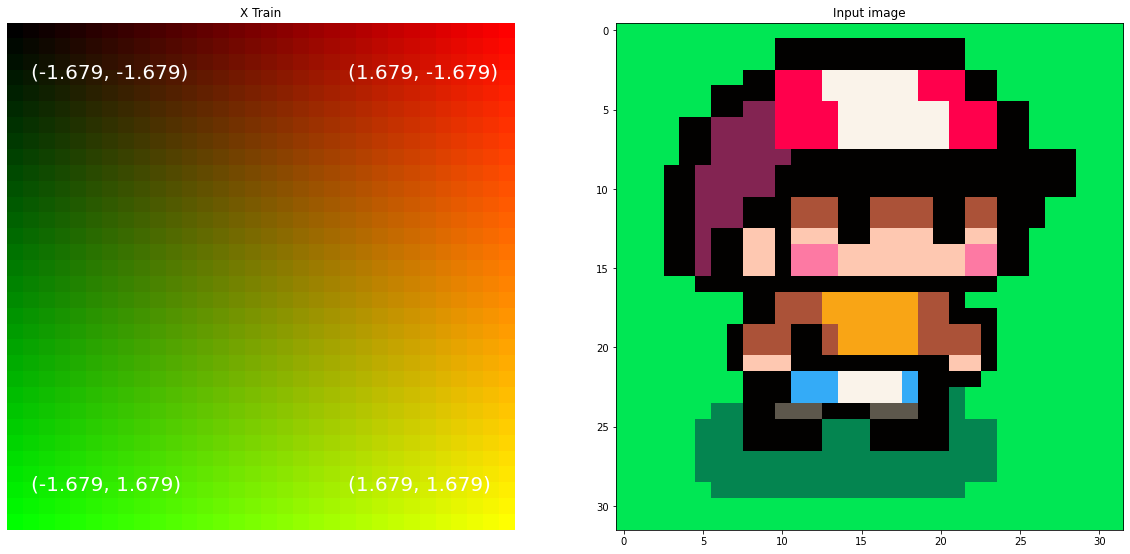

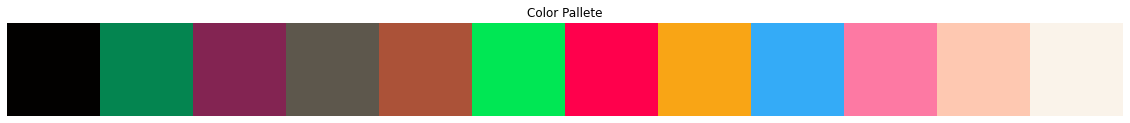

In [4]:
# Visualize data
fig, [axA, axB] = plt.subplots(1, 2)

ST = np.stack([S, T, S*0], axis=2)
ST = (ST - ST.min())/(ST.max() - ST.min())
ST[:,:,2] = 0
axA.imshow(ST); axA.axis('off')
axA.set_title('X Train')
axA.text(1, 3, f'({S.min():.3f}, {T.min():.3f})', color='w', size=20)
axA.text(21, 3, f'({S.max():.3f}, {T.min():.3f})', color='w', size=20)
axA.text(1, 29, f'({S.min():.3f}, {T.max():.3f})', color='w', size=20)
axA.text(21, 29, f'({S.max():.3f}, {T.max():.3f})', color='w', size=20)

axB.imshow(img_in)
axB.set_title('Input image')

# Color pallete
fig, ax = plt.subplots(1, 1)

ax.imshow(color_pallete[:, np.newaxis, :].reshape((1, -1, 3)))
ax.set_title('Color Pallete'); ax.axis('off')

plt.show()

## Data preparation
---

In [5]:
# Train data
X_train = np.array([S.ravel(), T.ravel()]).T

Y_train = np.array([R.ravel(), G.ravel(), B.ravel()]).T
Y_train_pallete = np.unique(Y_train, axis=0)
Y_train_pallete = Y_train_pallete[Y_train_pallete.sum(axis=1).argsort()]
# One-hot encoding based on the color pallete
Y_train_oh = np.zeros((Y_train.shape[0], Y_train_pallete.shape[0]))
n, m = Y_train_oh.shape
for i in range(Y_train_oh.shape[0]):
    for j in range(Y_train_oh.shape[1]):
        Y_train_oh[i, j] = 1 if np.array_equal(Y_train[i], Y_train_pallete[j]) else 0

In [6]:
# Test data
N1 = N2 = 640
t, s = np.mgrid[0:N1, 0:N2]
s = (s - s.mean())/s.std()
t = (t - t.mean())/t.std()
X_test = np.array([s.ravel(), t.ravel()], dtype=np.float32).T

## Deep Neural Network
---
The archtecture of the *NeuralNet* is inspired by the concept of a *decoder* of an *autoencoder*. The output is an *one-hot* encoding of the *color pallete*, which is activated by a *softmax* function.

In [7]:
# Avoid error: "InternalError:  Blas GEMM launch failed..." (RTX card)
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [8]:
### Define NN model
model = tf.keras.Sequential([
    tf.keras.layers.Input(2),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.125),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.125),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(m, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 24        
_________________________________________________________________
dense_1 (Dense)              (None, 32)                288       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 128)               4224      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               1

In [9]:
model.compile(
    loss='mean_squared_error',
    optimizer='adam',
    metrics=['accuracy']
)

# Train model
epochs = 100
for i in range(10):
    print(f'\nepochs: {i*epochs:04d} - {(i + 1)*epochs:04d}')
    model.fit(
        X_train, Y_train_oh,
        epochs=epochs - 1,
        verbose=0
    )
    # Verbose
    model.fit(
        X_train, Y_train_oh,
        epochs=1
    )


epochs: 0000 - 0100
Train on 1024 samples
1024/1024 [==============================] - 0s 85us/sample - loss: 0.0198 - accuracy: 0.8252

epochs: 0100 - 0200
Train on 1024 samples
1024/1024 [==============================] - 0s 83us/sample - loss: 0.0171 - accuracy: 0.8535

epochs: 0200 - 0300
Train on 1024 samples
1024/1024 [==============================] - 0s 85us/sample - loss: 0.0126 - accuracy: 0.8955

epochs: 0300 - 0400
Train on 1024 samples
1024/1024 [==============================] - 0s 83us/sample - loss: 0.0093 - accuracy: 0.9238

epochs: 0400 - 0500
Train on 1024 samples
1024/1024 [==============================] - 0s 84us/sample - loss: 0.0116 - accuracy: 0.9023

epochs: 0500 - 0600
Train on 1024 samples
1024/1024 [==============================] - 0s 85us/sample - loss: 0.0081 - accuracy: 0.9404

epochs: 0600 - 0700
Train on 1024 samples
1024/1024 [==============================] - 0s 84us/sample - loss: 0.0073 - accuracy: 0.9414

epochs: 0700 - 0800
Train on 1024 sample

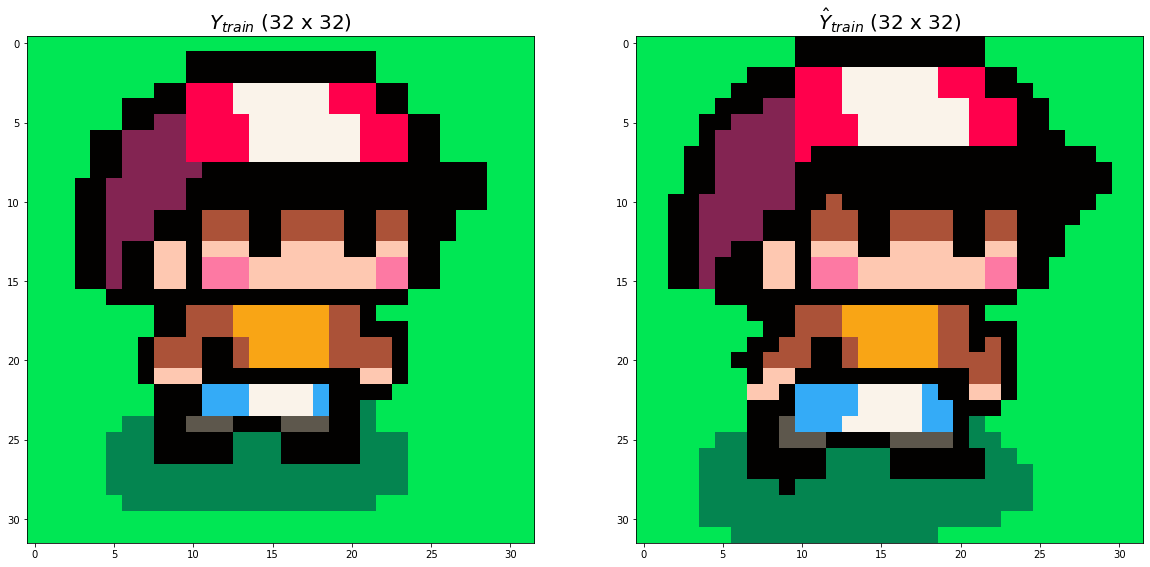

In [10]:
fig, [axA, axB] = plt.subplots(1, 2)

axA.imshow(img_in)
axA.set_title(f'$Y_{{train}}$ ({n1} x {n2})', size=20)
# Predict using X_train (32x32x3)
Y_predA = model.predict(X_train)
Y_predA = np.vstack(
    [Y_train_pallete[i] for i in np.argmax(Y_predA, axis=1)]
)
Y_predA = Y_predA.reshape(n1, n2, c)
axB.imshow(Y_predA)
axB.set_title(f'$\hat{{Y}}_{{train}}$ ({n1} x {n2})', size=20)

plt.show()

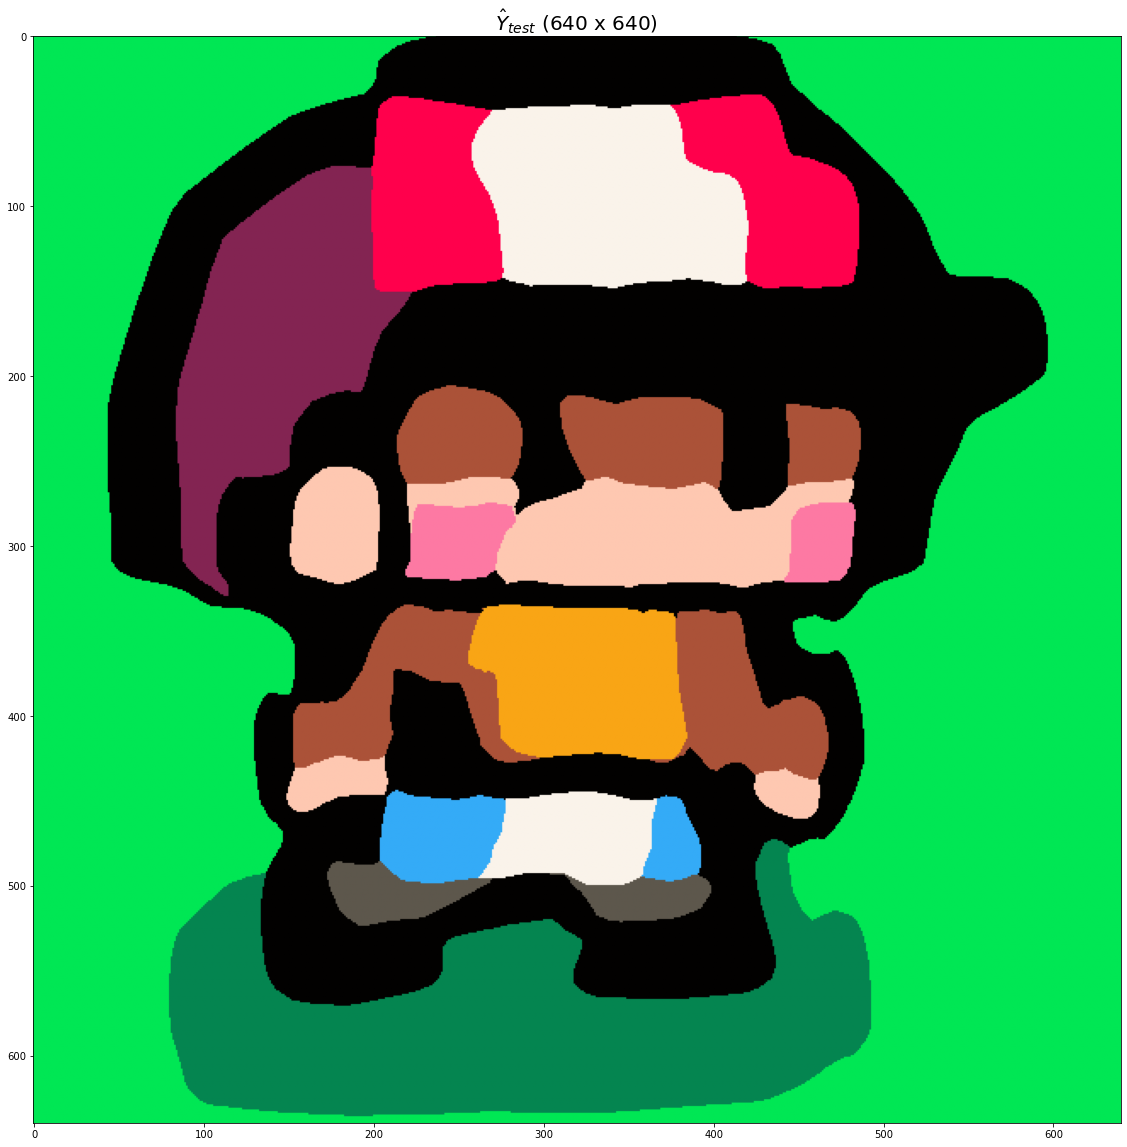

In [11]:
fig, axA = plt.subplots(1, 1, figsize=(20, 20))

# Predict using X_test (512x512x3)
Y_predB = model.predict(X_test)
Y_predB = np.vstack(
    [Y_train_pallete[i] for i in np.argmax(Y_predB, axis=1)]
)
Y_predB = Y_predB.reshape(N1, N2, c)
axA.imshow(Y_predB)
axA.set_title(f'$\hat{{Y}}_{{test}}$ ({N1} x {N2})', size=20)

plt.show()

## Learning process visualization
---

In [12]:
from IPython.display import IFrame

IFrame("https://www.youtube.com/embed/ROlbzTyWJDs", width="960", height="540")